In [98]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np
import seaborn as sns

# Generate set of data points from a sinusoid
num_points = 20
domain_min = 0
domain_max = 10

x = np.linspace(domain_min, domain_max, num_points)
data = 1.5*np.sin(1*x + 1) + 2

# add noise to the data
data += np.random.normal(0, .2, num_points)

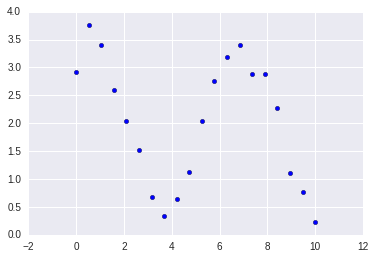

In [99]:
# Plot the data
plt.scatter(x, data)

In [100]:
# Define possible functions to fit
def sinusoid(domain, amplitude, frequency, offset, phase):
    return amplitude * np.sin(frequency*domain + phase) + offset

def polynomial(domain, coefficients):

    result = np.zeros(len(domain))
    for p, c in enumerate(coefficients):
        result += c*domain**p
        
    return result

In [101]:
# Define the objective function
def objective(args):
    
    if args['type'] == 'sinusoid':
        estimate = sinusoid(x, args['amplitude'], args['frequency'], args['offset'], args['phase'])
    elif args['type'] == 'polynomial':
        estimate = polynomial(x, args['coefficients'])
    
    # sum of squared error
    loss = np.sum(np.square(data - estimate))
    
    return {'loss': loss, 'status': STATUS_OK}

In [102]:
# Define the search space
space = hp.choice('function', [
        {'type':'sinusoid',
         'amplitude':hp.uniform('amplitude', 0.1, 2),
         'frequency':hp.uniform('frequency', 0.1, 2),
         'offset':hp.normal('offset', 0, 2),
         'phase':hp.normal('phase', 0, 2),
        },
        {'type':'polynomial',
         'coefficients':hp.choice('degree', [
                    [hp.normal('d0.c0', 0, 20)],
                    [hp.normal('d1.c0', 0, 20), hp.normal('d1.c1', 0, 20)],
                    [hp.normal('d2.c0', 0, 20), hp.normal('d2.c1', 0, 20), hp.normal('d2.c2', 0, 20)],
                    [hp.normal('d3.c0', 0, 20), hp.normal('d3.c1', 0, 20), hp.normal('d3.c2', 0, 20), hp.normal('d3.c3', 0, 20)],
                ]),

        },
    ])

In [103]:
# Create a Trials object to store results of each evaluation
trials = Trials()

# Run the search for the specified number of evaluations
best = fmin(objective,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=1000)

{'function': 0, 'phase': 1.009388536005037, 'frequency': 0.99341722427070178, 'amplitude': 1.393686038123459, 'offset': 1.9122835899444073}


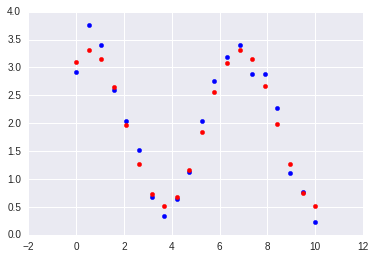

In [104]:
# Plot the fit found
print(best)
if best['function'] == 0:
    estimate = sinusoid(x, best['amplitude'], best['frequency'], best['offset'], best['phase'])
elif best['function'] == 1:
    deg = best['degree']
    coef = [best['d%s.c%s' % (deg, i)] for i in range(deg+1)]
    estimate = polynomial(x, coef)
plt.scatter(x,data,color='blue')
plt.scatter(x,estimate,color='red')